# NEURAL NETWORKS AND DEEP LEARNING

**First Homework by Luca Negri**

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## Introduction

This python notebook will contain both the code and the report for the first NNDL homework. It's divided in two main sections, that reflect the two tasks:
+ The **Regression task**, aimed at predicting the behaviour of a one dimensional input and output unknown function, througth the use of a fully connected neural network.
+ The **Classification task**, which will build a convolutional neural net able to classify images from the Fashion MNIST dataset into 10 different classes.

Both of these tasks will be accomplished using neural networks constructed in the pytorch framework. The hyperparameters will be optimized throught a Random search for the most important quantitites.
 

# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$



## Dataset
Before defining the dataset class, we will proceed to import all the major libraries that will be useful during the tasks

In [1]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

#others
import os
from tqdm import tqdm
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

These will be used to train and test the model. Each row contains two values, respactively the input and the target (label).

In [209]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

How to load the data:

In [150]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df  = pd.read_csv('regression_dataset/test_data.csv')

train_df

,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874
...,...,...
95,4.745864,5.839698
96,4.454523,3.584919
97,4.547246,4.586484
98,4.649648,5.185536


How to get a specific sample:

In [151]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


And here are all of the training and testing point that our network will try to guess. The x will be the input variable while it will try to guess the y value.

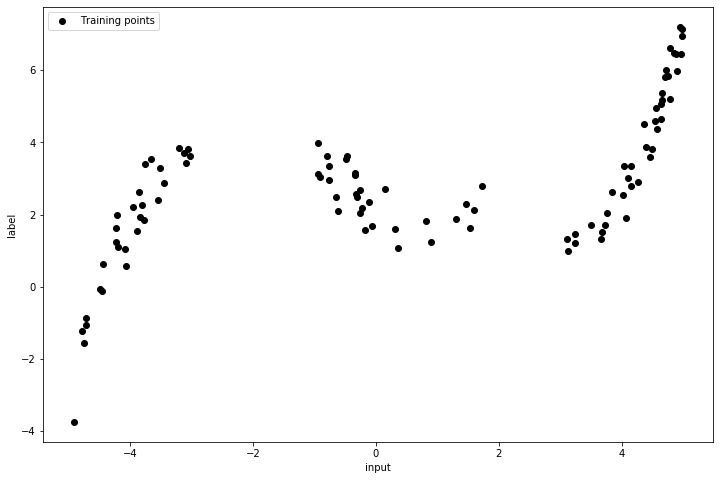

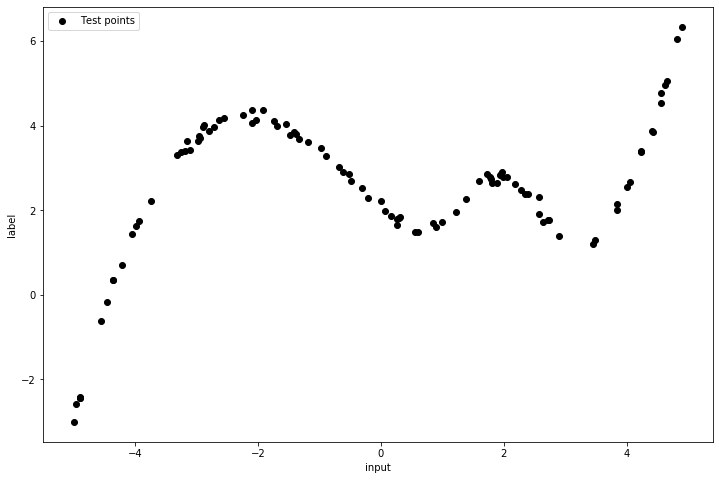

In [152]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points',color='black')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()
fig = plt.figure(figsize=(12,8))
plt.scatter(test_df.input, test_df.label, label='Test points',color='black')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

As we can see our training dataset is a noisy realization of the test set. If the regularization of the network is properly implemented this will help with reliability of the network, and also somehow simulates how real world data may behave.

## Definition of the dataset class
The class `pdDataset` will help to transform the dataset from a pandas dataframe to a more readable format for pytorch.

In [153]:
class pdDataset(Dataset):

    def __init__(self, df, transform=None):
        """
        Args:
            df (pands.DataFrame)          : Dataframe containing samples and labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        sample = self.data.iloc[idx]
        
        if self.transform:
            sample = self.transform(sample)
        return sample

## Definition of the Neural Network class
The architecture chosen to solve this problem is really simple : A fully connected Neural Network that has 2 hidden layers, an input and an output layer.
+ The input layer will have $N_{in}=1$ node, value fixed by the nature of the problem
+ The first hidden layer will have $N_{h1}$ nodes and will be a tunable parameter of our search
+ The second hidden layer will have $N_{h2}$ nodes and will be a tunable parameter as well
+ The last layer is the output and will have $N_{out}=1$ node, again, value fixed by the nature of our problem 


The number of nodes for $N_{}h1$ and $N_{h2}$ will be kept somehow limited, since there is a high risk of overfitting in such a simple regression task. The class also allows to have a specific initialization function, a specif activation and to choose the value of the dropout, wich will be parameters that our random search will try to optimize. The activation function is kept fixed as the *sigmoid* function for every layer except the last. 

In [154]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, Act,pDropout=0.3, init_func=nn.init.xavier_normal_ ):
        """
        Ni  - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No  - Output size
        Act - Activation function
        pDropout  - Dropout probability 
        init_func - Inizialization method
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        init_func(self.fc1.weight)

        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        init_func(self.fc2.weight)

        self.out = nn.Linear(in_features=Nh2, out_features=No)
        init_func(self.out.weight)

        self.act = Act
        self.dropout = nn.Dropout(pDropout)
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

## Definition of the transforms
To actually make the pandas dataframe readable to pytorch, the object needs to be transformed into a `tensor` object. To do this we define a simple tranform class that does this exact conversion. this transform will then be passed to the `pdDataset` class.

In [210]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
        
    

Now the funcion in the next cell will divide the dataset into a validation and a train dataset. The  previous defined functions will then be applied to the datasets. An 80 / 20 % train/validation size split has been chosen for the datasets, since it's usually the most used ratio for these kinds of tasks. Even if we are working with really small datasets this ratio is still considered adeguate. For the final test set a different dataset is used, since it represent the least noisy data.  

In [156]:
transform = transforms.Compose([ToTensor()])

train_samples_n = len(train_df)

train_fraction = int(0.8*train_samples_n)
train_ns        = np.random.choice(np.arange(train_samples_n),replace=False,size=train_samples_n)

train_data = pdDataset( train_df.iloc[ train_ns[:train_fraction] ] , transform=transform)
val_data   = pdDataset( train_df.iloc[ train_ns[train_fraction:] ] , transform=transform)
test_data  = pdDataset( test_df                   , transform=transform)
train_data[6]

(tensor([3.4972]), tensor([1.7237]))

## Training the network 
Now we will proceed to do a test training of the whole network to test that everything is working with some random hyperparameters choiche

### Train & test functions

These functions will help in the training and test phase of the project. 

+ `train_epoch` makes a single pass over all of the training data and updates the weights trought backpropagation of the gradient over the loss funcion `loss_fn` and optimizes it with the given user defined `optimizer`. It's also possbile to add an L1 regularization term by seting the `l1lambda` parameter different from 0.
+ `test_epoch` just evaluates the performance of the network over a specific dataset, giving as output the calculated loss, the real and the predicted labels of the given samples.
+ `train_func` autimates the train and evaluation steps for a given number of epochs.

In [163]:
def train_epoch(net, device, dataloader, loss_fn, optimizer, verbose=0, m = None, c = None, disable_tqdm=True, l1lambda = 0):
    """Function to advance training one step"""
    # Set train mode
    net.train()
    for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
        # Move tensors to the selected device
        train_batch = train_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(train_batch)
        # wether to apply regularization
        l1 = sum(p.abs().sum() for p in net.parameters())
        # Evaluate loss
        loss = loss_fn(out, label_batch) + l1lambda*l1
        
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        if verbose==2:
            print('\t Training loss (single batch):', float(loss.data))
            
            
### Testing function
def test_epoch(net, device, dataloader, loss_fn, m=None,disable_tqdm=True,l1lambda=0):
    # Set evaluation mode
    net.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        if m:
            conc_out = m(conc_out)
        l1 = sum(p.abs().sum() for p in net.parameters())
        val_loss = loss_fn(conc_out, conc_label) + l1lambda*l1
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss


def train_func(First_net , train_dataloader ,val_dataloader , device, loss_fn, optimizer,verbose = 1, num_epochs=50, m=None, disable_tqdm=True,l1lambda=0 ):
    ### TRAINING!

    train_losses = []
    val_losses = []
    
    tqdm_upper = True
    if verbose == 0 :
        tqdm_upper = False
        
    for epoch in tqdm(range(num_epochs),position=0,leave=True,disable=tqdm_upper):
        if verbose >= 1:
            print(f"EPOCH {epoch + 1}/{num_epochs}")
        ### Training 
        train_epoch(
            net=First_net,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer,
            verbose=verbose,m=m,
            disable_tqdm=disable_tqdm,
            l1lambda=l1lambda)

        ### Train loss 
        _, _, train_loss = test_epoch(
            net=First_net,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn,m=m,
            disable_tqdm=disable_tqdm,
            l1lambda=l1lambda)

        # Print Train loss
        if verbose >=1:
            print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
        train_losses.append(train_loss)

        ### Validation 
        _, _, val_loss = test_epoch(
            net=First_net,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn,m=m,
            disable_tqdm=disable_tqdm)

        # Print Validation loss
        if verbose>=1:
            print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
        val_losses.append(val_loss)
        
    return train_losses, val_losses


To pass the dataset to the network durning training the choice to divide it into batches has been taken. this will both speed up the training and help with avoiding overfitting. The batches will be 8 samples each and will be random shuffled each time.

We define here both the loss function and the algorithm that will try to optimize it. For regression problems the usual loss function chosen is the **mean squared error**, which is just the squaere of the difference between the prediciton and the real result. Fot the optinimizer the Adam algorithm is chosen, since in most machine learning application seems to be the best performing one. 

In [171]:


train_dataloader = DataLoader(train_data , batch_size=8           , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_data   , batch_size=len(val_data) , shuffle=False , num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
Ni = 1
Nh1 = 64
Nh2 = 64
No = 1
act = nn.Sigmoid()
net = Net(Ni, Nh1, Nh2, No, act , init_func=nn.init.xavier_normal_)
net.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=2e-3)

net(train_data[78][0].to(device))


Training device: cpu
Network initialized


tensor([-0.9558], grad_fn=<AddBackward0>)

In [172]:
train_loss_log, val_loss_log = train_func(net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs=400, disable_tqdm=True, l1lambda=1e-4)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 29.30it/s]


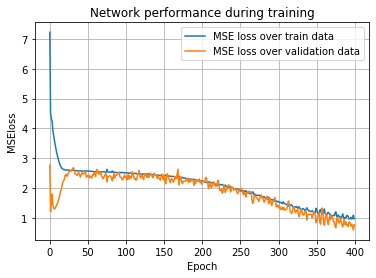

In [173]:
plt.plot(train_loss_log, label = 'MSE loss over train data')
plt.plot(val_loss_log, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

As we can see the network is training as we expected. We do not see any strong indication of overfitting and so the order of magnitude of the neuron chosen is adeguate. For this training a L1 type of regularization was used and seems to be helping.

## Random search

To tune the hyperparamers, a random search approach was chosen, where some user defined parameters are randomly chosen at each iteration from a small list. This method of search has a few advantages over, for example, a Grid Search approach, since it does have less biases and the resolution of the search can be imrpoved on the fly.

To actually compare different hyperparameters realizations, we use a Cross Validation setup, which is a tecnique that divides the training dataset into $k$ parts, and in turns each of these "folds" will be part of the training or the validation dataset. This ensures that no bias exist in the choice of the best hyperparametr given by the arbitrary choice of validation and training set. The actual function used in this setup are:

+ `KFoldDivider` divides the dataset into `n_folds` datasets
+ `RandomSearch` actually performs the search. Some parameters are preselected and the function performs the cross validation setup. It returns a dataframe containing the paramteres of the train, the mean loss oveer the cross validation and the loss evolution during training for each fold.

In [179]:
def KFoldDivider(train_data, train_data_size , n_folds=4):
    """Function to divide in different folds the train set"""
    test_size = int(train_data_size/n_folds)
    
    cvs = []
    
    total_data = train_data
    
    for i in range(n_folds-1):
    
        total_data , cv_data = train_test_split(total_data, test_size=test_size, shuffle=True, random_state=0)
        
        cvs.append(cv_data)
    cvs.append(total_data)
    
    return cvs
    

In [180]:
def RandomSearch(params_to_choose, Net_class, train_dataset, n_folds = 4 , n_points = 5):
    """random search of hyper parameters"""

    cvs = KFoldDivider(train_dataset,len(train_dataset),n_folds)

    result_df_columns = ['mean_loss'] + list(params_to_choose.keys()) + ['losslog_cv' + str(i) for i in range(n_folds)] 

    results = pd.DataFrame(np.zeros((n_points,len(result_df_columns))),
                           columns = result_df_columns, dtype=object)

    Ni , No = 1 , 1
    act = nn.Sigmoid()    

    for i in range(n_points):

        params   = {}
        for param in params_to_choose.keys():
            params[param] = np.random.choice(params_to_choose[param])

            results[param][i] = params[param]

        print('ITERATION N ' + str(i+1))
        print('PARAMS:\n' )
        for value,name in zip(params.values(),params.keys()):
            print(name,'     \t :',value)

        val_cv_losses = []

        mean_loss = 0

        for j in range(n_folds):

            train_cv = cvs.copy()
            val_cv   = train_cv.pop(j)
            train_cv = pd.concat(train_cv)

            train_data = pdDataset( train_cv , transform=transform)
            val_data   = pdDataset( val_cv   , transform=transform)


            train_dataloader = DataLoader(train_data , batch_size=8             , shuffle=True  , num_workers=0)
            val_dataloader   = DataLoader(val_data   , batch_size=len(val_data) , shuffle=False , num_workers=0)  


            Nh1,Nh2   = params['Nh1'] , params['Nh2']
            init_func = params['init_func']
            p_drop    = params['p_drop']
            net       = Net_class(Ni, Nh1, Nh2, No, act , init_func=init_func)
            net.to(device)

            loss_fn = params['loss_fn']

            optimizer = params['optimizer']
            optimizer = optimizer(net.parameters(),lr=params['lr'])

            _ , val_loss_log = train_func(net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs = params['num_epochs'], disable_tqdm=True,
                                          l1lambda=params['l1lambda'])

            results['losslog_cv' + str(j) ][i] = val_loss_log
            mean_loss += val_loss_log[-1]     

        results['mean_loss'][i] = mean_loss/n_folds
    return results

The parameter that this search is aimed at optimizing are:
+ The sizes of the 2 hidden layers
+ The optimal inizialization function, between the uniform, the normal and the xavier normal functions
+ The dropout probabiity
+ The optimizer, with a choice between Adam, Adamax or a simple SGD
+ The learning rate
+ The total number of epochs
+ The L1 regularization term $\lambda$

In [181]:
params_to_choose = {  'Nh1'       : [64,128,256],
                      'Nh2'       : [64,128,256],
                      'init_func' : [nn.init.xavier_normal_,nn.init.uniform_,nn.init.normal_],
                      'p_drop'    : [0.0,0.1,0.3,0.4],
                      'loss_fn'   : [nn.MSELoss()],
                      'optimizer' : [optim.Adam, optim.SGD, optim.Adamax ],
                      'lr'        : [1e-4,1e-3,1e-2],
                      'num_epochs': [300,400],
                      'l1lambda'  : [1e-4,1e-5,0] }

In [182]:
results = RandomSearch(params_to_choose,Net,train_df,n_points=10)

ITERATION N 1
PARAMS:

Nh1      	 : 256
Nh2      	 : 128
init_func      	 : <function uniform_ at 0x0000016806B36048>
p_drop      	 : 0.0
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.sgd.SGD'>
lr      	 : 0.01
num_epochs      	 : 400
l1lambda      	 : 1e-05
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 23.64it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:17<00:00, 23.40it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:18<00:00, 21.79it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:18<00:00, 21.57it/s]


ITERATION N 2
PARAMS:

Nh1      	 : 64
Nh2      	 : 64
init_func      	 : <function normal_ at 0x0000016806B360D0>
p_drop      	 : 0.3
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
lr      	 : 0.01
num_epochs      	 : 300
l1lambda      	 : 0.0
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.06it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 27.26it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 27.12it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.45it/s]


ITERATION N 3
PARAMS:

Nh1      	 : 64
Nh2      	 : 128
init_func      	 : <function normal_ at 0x0000016806B360D0>
p_drop      	 : 0.0
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
lr      	 : 0.001
num_epochs      	 : 400
l1lambda      	 : 0.0001
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.52it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.91it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.68it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.02it/s]


ITERATION N 4
PARAMS:

Nh1      	 : 64
Nh2      	 : 128
init_func      	 : <function normal_ at 0x0000016806B360D0>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
lr      	 : 0.01
num_epochs      	 : 400
l1lambda      	 : 0.0
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.57it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.02it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.03it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.24it/s]


ITERATION N 5
PARAMS:

Nh1      	 : 256
Nh2      	 : 64
init_func      	 : <function uniform_ at 0x0000016806B36048>
p_drop      	 : 0.3
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
lr      	 : 0.0001
num_epochs      	 : 300
l1lambda      	 : 0.0
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.22it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.71it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.17it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.70it/s]


ITERATION N 6
PARAMS:

Nh1      	 : 256
Nh2      	 : 128
init_func      	 : <function normal_ at 0x0000016806B360D0>
p_drop      	 : 0.0
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
lr      	 : 0.01
num_epochs      	 : 400
l1lambda      	 : 1e-05
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:20<00:00, 19.99it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:20<00:00, 19.77it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:20<00:00, 19.17it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:20<00:00, 19.57it/s]


ITERATION N 7
PARAMS:

Nh1      	 : 128
Nh2      	 : 128
init_func      	 : <function xavier_normal_ at 0x0000016806B36598>
p_drop      	 : 0.1
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
lr      	 : 0.01
num_epochs      	 : 400
l1lambda      	 : 0.0
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.59it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.92it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 23.64it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:17<00:00, 22.81it/s]


ITERATION N 8
PARAMS:

Nh1      	 : 256
Nh2      	 : 64
init_func      	 : <function xavier_normal_ at 0x0000016806B36598>
p_drop      	 : 0.0
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
lr      	 : 0.01
num_epochs      	 : 300
l1lambda      	 : 0.0001
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.96it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.47it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 23.07it/s]


ITERATION N 9
PARAMS:

Nh1      	 : 64
Nh2      	 : 256
init_func      	 : <function uniform_ at 0x0000016806B36048>
p_drop      	 : 0.4
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.sgd.SGD'>
lr      	 : 0.01
num_epochs      	 : 300
l1lambda      	 : 1e-05
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.25it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.43it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.20it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.80it/s]


ITERATION N 10
PARAMS:

Nh1      	 : 128
Nh2      	 : 64
init_func      	 : <function normal_ at 0x0000016806B360D0>
p_drop      	 : 0.0
loss_fn      	 : MSELoss()
optimizer      	 : <class 'torch.optim.sgd.SGD'>
lr      	 : 0.01
num_epochs      	 : 300
l1lambda      	 : 0.0001
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 27.00it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.54it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.78it/s]


Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.46it/s]


### Best results, final train &  test

These are the best results of the random search, so now we will perform one last training of the network with these parameters.

The Adam class of optimizers results to be the best suited for achieving the wanted result. With decently high learning rates. Introducing dropout also helps to generalize more the results and achieve better performance over the validation. 

In [185]:
results

,mean_loss,Nh1,Nh2,init_func,p_drop,loss_fn,optimizer,lr,num_epochs,l1lambda,losslog_cv0,losslog_cv1,losslog_cv2,losslog_cv3
0,tensor(22.4553),256,128,<function uniform_ at 0x0000016806B36048>,0,MSELoss(),<class 'torch.optim.sgd.SGD'>,0.01,400,1e-05,"[tensor(32816996.), tensor(3.2884e+11), tensor...","[tensor(20607816.), tensor(1.6517e+11), tensor...","[tensor(40474000.), tensor(2.1271e+08), tensor...","[tensor(24735944.), tensor(3.8782e+11), tensor..."
1,tensor(1.0399),64,64,<function normal_ at 0x0000016806B360D0>,0.3,MSELoss(),<class 'torch.optim.adam.Adam'>,0.01,300,0,"[tensor(7.7006), tensor(2.7313), tensor(3.6973...","[tensor(5.6784), tensor(4.6176), tensor(3.0429...","[tensor(7.6928), tensor(8.0291), tensor(5.2533...","[tensor(5.8602), tensor(3.7069), tensor(4.0672..."
2,tensor(2.2932),64,128,<function normal_ at 0x0000016806B360D0>,0,MSELoss(),<class 'torch.optim.adam.Adam'>,0.001,400,0.0001,"[tensor(9.7768), tensor(5.5109), tensor(5.1584...","[tensor(15.2457), tensor(7.8334), tensor(4.168...","[tensor(10.3539), tensor(9.8305), tensor(9.366...","[tensor(10.2001), tensor(4.5964), tensor(3.386..."
3,tensor(2.2665),64,128,<function normal_ at 0x0000016806B360D0>,0.4,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.01,400,0,"[tensor(14.6963), tensor(7.3965), tensor(3.846...","[tensor(7.2004), tensor(23.5619), tensor(36.57...","[tensor(7.0705), tensor(4.7309), tensor(6.1529...","[tensor(21.2965), tensor(8.8470), tensor(5.536..."
4,tensor(275.6580),256,64,<function uniform_ at 0x0000016806B36048>,0.3,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.0001,300,0,"[tensor(933.5655), tensor(930.6863), tensor(92...","[tensor(587.8503), tensor(585.6218), tensor(58...","[tensor(941.4515), tensor(938.5405), tensor(93...","[tensor(987.1475), tensor(984.1672), tensor(98..."
5,tensor(2.0537),256,128,<function normal_ at 0x0000016806B360D0>,0,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.01,400,1e-05,"[tensor(10.0963), tensor(10.3531), tensor(7.52...","[tensor(7.1752), tensor(6.4650), tensor(3.8608...","[tensor(6.5153), tensor(9.6138), tensor(11.407...","[tensor(7.9182), tensor(14.2248), tensor(19.79..."
6,tensor(0.5461),128,128,<function xavier_normal_ at 0x0000016806B36598>,0.1,MSELoss(),<class 'torch.optim.adam.Adam'>,0.01,400,0,"[tensor(7.0528), tensor(4.8295), tensor(4.2833...","[tensor(5.2215), tensor(2.5539), tensor(2.1475...","[tensor(2.0023), tensor(1.8746), tensor(2.3219...","[tensor(3.9115), tensor(2.9501), tensor(2.5691..."
7,tensor(0.5914),256,64,<function xavier_normal_ at 0x0000016806B36598>,0,MSELoss(),<class 'torch.optim.adamax.Adamax'>,0.01,300,0.0001,"[tensor(5.4983), tensor(5.4186), tensor(4.8170...","[tensor(3.7507), tensor(3.1109), tensor(3.1786...","[tensor(2.1517), tensor(1.8063), tensor(1.9559...","[tensor(3.8113), tensor(3.4130), tensor(3.2135..."
8,tensor(3.0668),64,256,<function uniform_ at 0x0000016806B36048>,0.4,MSELoss(),<class 'torch.optim.sgd.SGD'>,0.01,300,1e-05,"[tensor(60.3527), tensor(17.0348), tensor(17.2...","[tensor(9.1240), tensor(10.7132), tensor(13.34...","[tensor(5025.0508), tensor(234.1752), tensor(6...","[tensor(192.7379), tensor(97.4864), tensor(82...."
9,tensor(2.5781),128,64,<function normal_ at 0x0000016806B360D0>,0,MSELoss(),<class 'torch.optim.sgd.SGD'>,0.01,300,0.0001,"[tensor(5.7684), tensor(3.9982), tensor(4.0740...","[tensor(2.4189), tensor(14.1718), tensor(3.402...","[tensor(2.1454), tensor(5.5403), tensor(7.4291...","[tensor(5.8632), tensor(7.6631), tensor(5.4321..."


In [183]:
best_results = results.loc[results.mean_loss.apply(float).idxmin()]
best_results

mean_loss                                         tensor(0.5461)
Nh1                                                          128
Nh2                                                          128
init_func        <function xavier_normal_ at 0x0000016806B36598>
p_drop                                                       0.1
loss_fn                                                MSELoss()
optimizer                        <class 'torch.optim.adam.Adam'>
lr                                                          0.01
num_epochs                                                   400
l1lambda                                                       0
losslog_cv0    [tensor(7.0528), tensor(4.8295), tensor(4.2833...
losslog_cv1    [tensor(5.2215), tensor(2.5539), tensor(2.1475...
losslog_cv2    [tensor(2.0023), tensor(1.8746), tensor(2.3219...
losslog_cv3    [tensor(3.9115), tensor(2.9501), tensor(2.5691...
Name: 6, dtype: object

In [186]:
train_dataloader = DataLoader(train_data , batch_size=8             , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_data   , batch_size=len(val_data) , shuffle=False , num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
Ni = 1
Nh1 = best_results.Nh1
Nh2 = best_results.Nh2
No = 1
act = nn.Sigmoid()
net = Net(Ni, Nh1, Nh2, No, act , init_func=best_results.init_func)
net.to(device)

loss_fn =  best_results.loss_fn

optimizer = best_results.optimizer(net.parameters(), lr= best_results.lr)

net(train_data[78][0].to(device))


Training device: cpu
Network initialized


tensor([-1.2289], grad_fn=<AddBackward0>)

In [187]:
train_loss_log, val_loss_log = train_func(net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs=best_results.num_epochs, disable_tqdm=True,
                                          l1lambda=best_results.l1lambda)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:15<00:00, 25.97it/s]


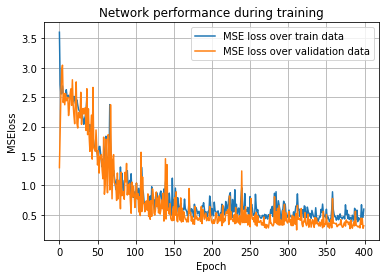

In [188]:
plt.plot(train_loss_log, label = 'MSE loss over train data')
plt.plot(val_loss_log, label = 'MSE loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('MSEloss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

As we can see better results were obtained from before, with a loss of under 0.5 for the validation. Obviusly these data points are really subjected to noise, given the small number of samples that we are working on. But the low dimensionality of the output and input space means that we can still obtain decent results.

Now we will proceed to visualize the performance of the network, by visualizing the real and the predicted data points for the validation and test sets.

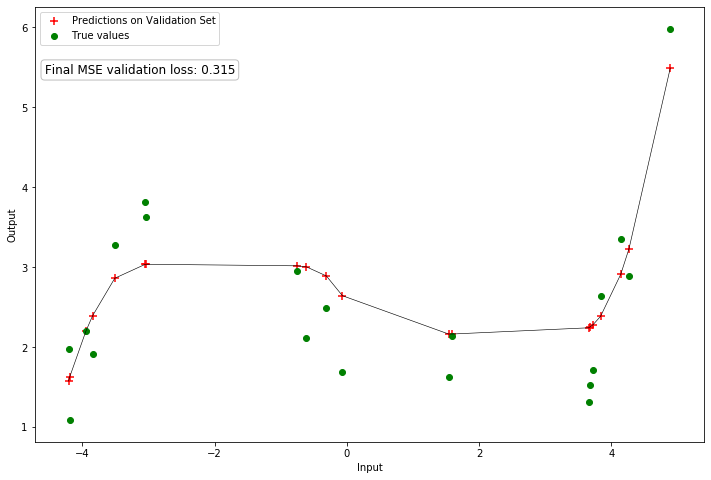

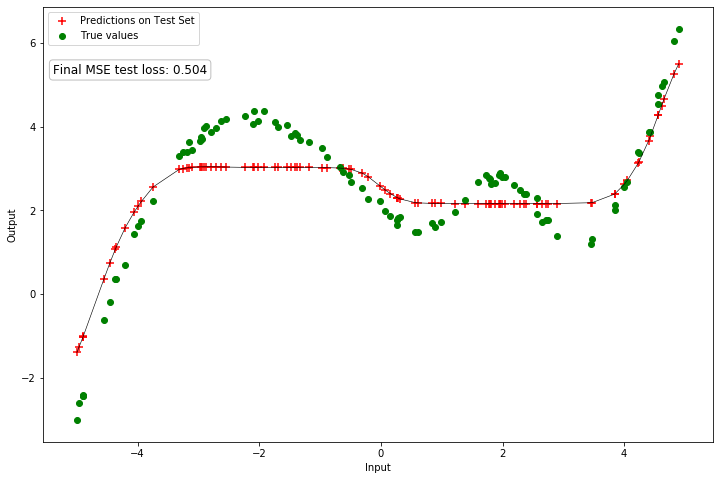

In [189]:

x_val  = torch.Tensor(train_df.iloc[ train_ns[train_fraction:] ].input.sort_values().tolist() )
y_val  = torch.Tensor(train_df.iloc[ train_ns[train_fraction:] ].sort_values('input').label.tolist() )

test_df = test_df.sort_values('input')

x_test = torch.Tensor(test_df.input.tolist() )
y_test = torch.Tensor(test_df.label.tolist() )

#x_vec = x_vec.to(device)
x_val = x_val.unsqueeze(-1)
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_val_predicted = net(x_val.to(device))

fig,ax = plt.subplots(figsize=(12,8))
ax.plot(x_val.cpu(), y_val_predicted.cpu(),color='black',linewidth=0.6)
ax.scatter(x_val.cpu(), y_val_predicted.cpu(), label='Predictions on Validation Set',color='red',s=50,marker='+')
plt.scatter(x_val,y_val,color='green',label='True values')
textstr = f"Final MSE validation loss: {float(val_loss_log[-1]):.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.015,0.87, textstr, fontsize=12,
        verticalalignment='top',bbox=props,transform=ax.transAxes)
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.legend()
plt.show()

x_test = x_test.unsqueeze(-1)
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_test_predicted = net(x_test.to(device))
    _, _, val_loss = test_epoch(
        net=net,
        device=device, 
        dataloader=test_data, 
        loss_fn=loss_fn)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(x_test.cpu(), y_test_predicted.cpu(),color='black',linewidth=0.6)
ax.scatter(x_test.cpu(), y_test_predicted.cpu(), label='Predictions on Test Set',color='red',s=50,marker='+')
ax.scatter(x_test.cpu(),y_test.cpu(),color='green',label='True values')
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.legend()

textstr = f"Final MSE test loss: {float(val_loss):.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.015,0.87, textstr, fontsize=12,
        verticalalignment='top',bbox=props,transform=ax.transAxes)

plt.show()

As we can see we obtain quite decent result. The visual inspection reveals that the network imitaded quite well the behaviour of the output, without quite getting the behaviour at the extremes.

When inspecting the performance on the test set we see that the prediction does not match in some regions of the input space. If we inspect the training set it's possible to notice that in these regions there were no samples that the network could learn from, so the drop in performance in these regions is totally to be expected.

## Weights visualization

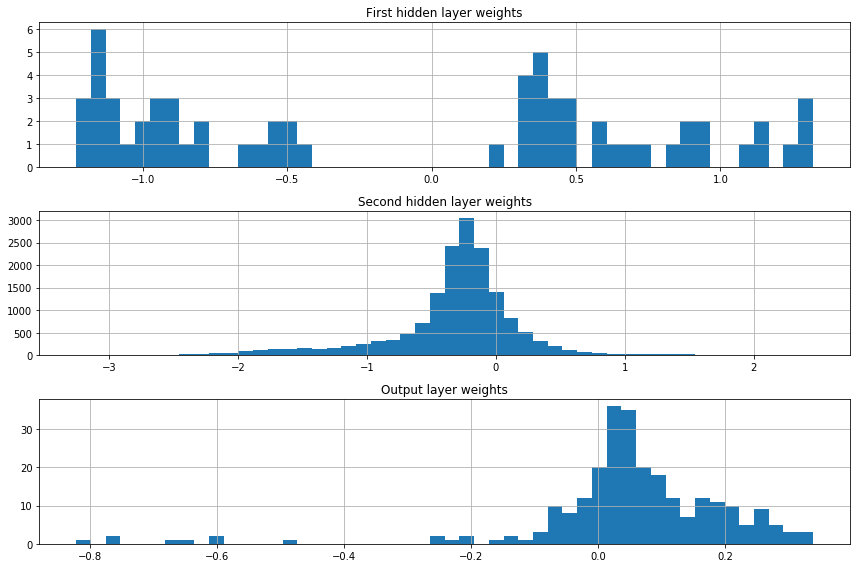

In [107]:
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

The weight distributions follow a mostly random pattern, but some structures can be seen. 
+ the first layer lacks the number of weights needed to perform meaningful statistichs, but a more or less uniform distribution can be seen between -1 and 1, with a notable lack of weights around 0.
+ The second layer of weights, the most popolous, we can se a gaussian-like distribution around 0 , with really long tails.
+ The last weight layer, similar to the first, is not so much populated, but a concentration around 0 can also be seen, like the second layer.

Now we'll take a look at the activation profiles. we will try to see how the last layer of the network behaves when given as input -4, 0 and 4 , wich represent the axtremes and the middle of the spectrum of inputs.

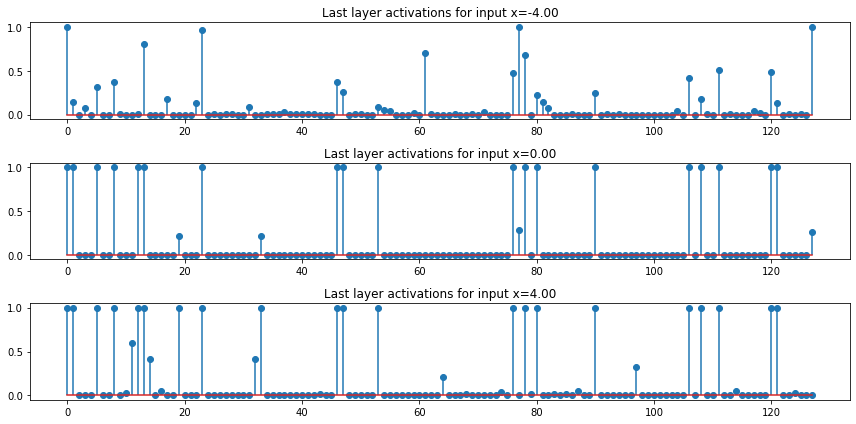

In [190]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([4]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

The activation profiles do not gice much insight in the performance of the network. it's still interesting to note how some neurons are always firing in these cases, and also the fact that the number of activated neurons grows as we proceed from the smallest to the biggest input, reflecting the fact that the function that it's tring to learn is has an increasing behaviour.

## Results.

In the end we can say that our fully connected neural network with 2 layers is capable of capturing the structure of our one dimensional output function. From the random search the Optimal sizes seem to be for $N_{h1}$ 128 and for $ N_{h2}$ 128.


Regularizations and dropouts help in fighting overfitting of the net, resulting in an overall improvement in the performance. The dropout seems  to be most effective in the 0.2-0.3 range, since outside this range it's either too small to impact anything or it interferes too much in training. Adam/Adamx algorithms perform almost always better than sotchastic gradient descent, since they are way more advanced and implement strategies such as momentum. The drop in performance in the test set with respect to the validation is mostly due to how biased the training set was chosen, since it's missing entire regions of the input space that are crossed by the test set, so it's not surprising that the network is not able to predict the correct behaviour in these regions. Interestingly the fact that the input was noisy did not impact much the performances of the network, in fact it may have even improved it, since it prevented overfitting.

In the future some input manipulation and better choice of training set could be implemented to improve the performances.

# Classification task
***
The objective now is to create a convolutional neural network that is capable of correctly labelling images of items of clothing, coming from the Fashion MNIST dataset. This dataset has been used extensively in this kind of application, so it's really well studied and is a standard benchmark to evaluate the perfomamnces of different machine learning models.

## Dataset

In [358]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

Download the dataset:

In [371]:
total_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

The images are formed by 28 x 28 pixels, with only one channel, so they are in black and white. The item of clothing belong to 10 different classes. Here we can see come examples.

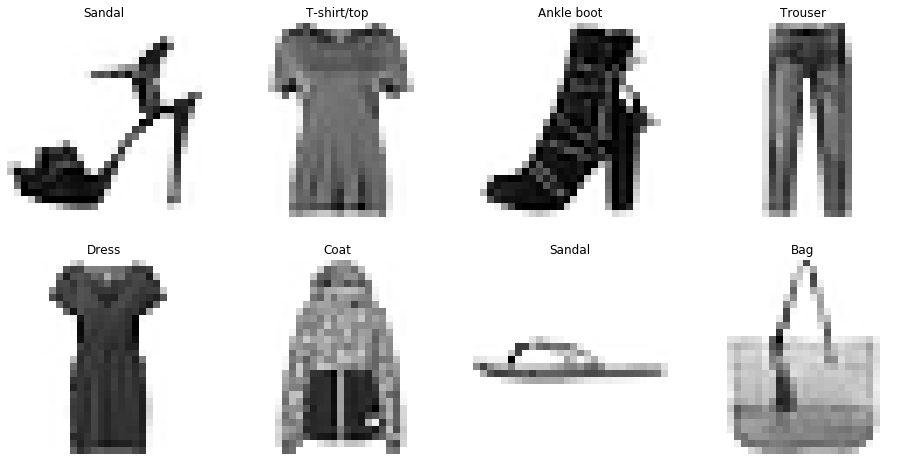

In [372]:
#sample_index = 10
#image = train_dataset[sample_index][0]
#label = train_dataset[sample_index][1]
classes = total_dataset.classes
fig = plt.figure(figsize=(16,8))
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = total_dataset[sample_index][0]
    label = total_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image, cmap='Greys')
    plt.title(classes[label])
    plt.axis('off')
plt.show()

The total list of classes of items of clothing is
+ T-shirt
+ Trouser
+ Pullover
+ Dress
+ Coat
+ Sandal
+ Shirt
+ Sneaker
+ Bag
+ Ankle boot

These classes are mutually esclusive, meaning that each sample has only one label.

As we did before, a series of transformations is applied to the samples. Other than the usual tensor transformation a random White noise is also added.The noises changes every time the sample is called. This could help reduce overfitting in the network training.

The training set is divided further into an actual training set and a validation set,as before, an 80 - 20 % split has been chosen for the train and validation sets.. With the dataloader then the different sets are divided into batches that will also help in the training process.

In [373]:
class WhiteNoise():
    """Class aimed at transforming a dataset adding random gaussian noise to the input variables"""
    def __init__(self, mu = 0.0 , std = 1.0):
        self.mu  = mu
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mu

In [383]:
WNoiseTransform = WhiteNoise( std = 0.05)

Image_transforms = transforms.Compose([
    transforms.ToTensor(),
    WNoiseTransform,
    #transforms.RandomRotation(degrees = 45)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [386]:
#labels = [train_dataset[i][1] for i in range(len(train_dataset))]



#train_data ,val_data = train_test_split(train_dataset,  test_size=0.1, stratify=labels, shuffle=True, random_state=0)

val_split = 0.2

Ntot   = len(total_dataset)
Nval   = int(Ntot * val_split)
Ntrain = Ntot - Nval

train_dataset, val_dataset = torch.utils.data.random_split(total_dataset, [Ntrain, Nval])


test_dataset.transform  = test_transforms
val_dataset.dataset.transform   = test_transforms
train_dataset.dataset.transform = Image_transforms

num_workers = 0 #PC
#num_workers = 2 #####COLAB ENABLED
batch_size = 256
train_dataloader = DataLoader(train_dataset , batch_size = batch_size        , shuffle = True  , num_workers=num_workers)
val_dataloader   = DataLoader(val_dataset   , batch_size = len(val_dataset)  , shuffle = True  , num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset  , batch_size = len(test_dataset) , shuffle = False , num_workers=num_workers)

In [387]:
val_dataset.dataset.transform

Compose(
    ToTensor()
)

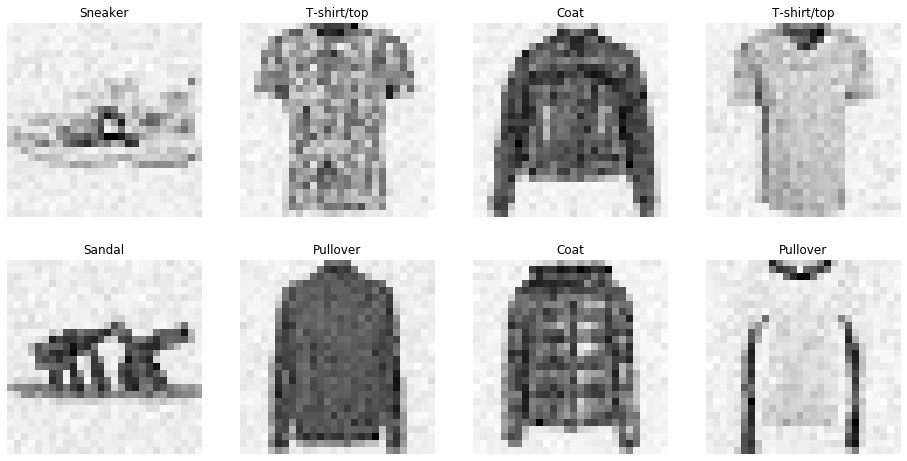

In [388]:
fig = plt.figure(figsize=(16,8))
for sample_index,nplot in zip([9,10,11,16,20,22,30,35],range(241,249)):
    image = train_dataset[sample_index][0].squeeze(0)
    label = train_dataset[sample_index][1]
    fig.add_subplot(nplot)
    plt.imshow(image, cmap='Greys')
    plt.title(classes[label])
    plt.axis('off')
plt.show()

## Convolutional Net Class
Here we define the actual convolutional network that will be used in this task. The architecture is organized like so:
+ A first convolutional layer. The user can define the kernel size ($K_1$) and the number of channels ($N_{ch1}$). the stride and the padding are fixed and cannot be modified, they are fixed respectively at 2 and 1
+ A second convolutional layer with as input the channels of the last one , with his own tunable $K_2$ and $N_{ch2}$. The same approach has been taken for the stride and the padding as above.
+ A flattening step, to make the jump from convolutional to fully connected network
+ A fully connected layer with a tunable number of nodes ($N_h$)
+ An output layer with the number of nodes equal to the number of classes.

The user can also define in the network inizialization the dropout probability, the input size and the inizialization scheme. Since in the previous step we saw that the xavier normal seems to be the best performing inizialization this will be kept in this task as fixed. another fixed parameter is the activation function, wich for every layer is kept as the ReLU function, except for the last layer that outputs directly the neurons value.


In [389]:
def init_weights(m):
    """Function to initialize weights in a layer"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        
        # gain is a parameter to be given to the xavier normal to decide the std, depends on the activation
        torch.nn.init.xavier_normal_(m.weight , torch.nn.init.calculate_gain( 'relu' ) )
        m.bias.data.fill_(0.01)

In [390]:
class ConvNet(nn.Module):
    
    """Network class, contains 3 hidden layers"""
    
    def __init__(self, InputSize,  No, NChannels = [8,16] ,KSize = [(3,3),(3,3)],FCLSize = 128, 
                 pDropout=0.0, init_func=init_weights):
        """
        Args:
        InputSize (tuple)                 : Input size of the image (e.g. (28,28))
        No (int)                          : Output size
        NChannels (series ofin of  len 2) : List of the number of channels
        Ksize (series of tuples of len 2) : List of the number of Kernel sizes
        FCLSize (int)                     : Fully connected Layer Size
        pDropout (float [0,1] )           : Probability of dropout
        init_func (nn.init function)      : Function to be applied to inizialize Tensors 
        """
        super().__init__()
        
        print('Network initialized')
        self.ConvLayer = torch.nn.Sequential(
            
            #First Conv layer
            nn.Conv2d(in_channels=1, out_channels=NChannels[0], kernel_size=KSize[0], 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True),

            
            #Second Conv Layer
            nn.Conv2d(in_channels=NChannels[0], out_channels=NChannels[1], kernel_size=KSize[1], 
                      stride=2, padding=1),
            torch.nn.Dropout(pDropout),
            nn.ReLU(True)
            
        )

        #The Flattening
        self.flatten = nn.Flatten(start_dim=1)
        
        # Ugly hack to calculate on the fly the dimension of the last convolutional layer
        # By passing a dummy sample image with same dimension as the expected input 
        InputSize = (1,1)+InputSize
        dummy_sample_image = torch.zeros(InputSize)
        FlatConvSize = self.flatten(self.ConvLayer(dummy_sample_image)).shape[1]
        
        #FC passage
        self.FCLayer = torch.nn.Sequential(
            
            torch.nn.Linear(FlatConvSize,FCLSize),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),

            #Output Layer
            torch.nn.Linear(FCLSize,No)
            
        )
        
        #Inizialization
        self.ConvLayer.apply(init_func)
        self.FCLayer.apply(init_func)

        
    def forward(self, x):
        x = self.ConvLayer(x)
        x = self.flatten(x)
        x = self.FCLayer(x)
        return x

## Training
Here we first try the network to see if everything is working smoothly

In [391]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
In        = (28,28)
Out       = 10
NChannels = [4,8]
Ksize     = [(4,4)]*2
FCLSize   = 64

Net = ConvNet(In,Out,NChannels,Ksize,FCLSize)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(Net.parameters(), lr=2e-3)

Net(train_dataset[78][0].unsqueeze(0).to(device))

Training device: cpu
Network initialized


tensor([[ 0.5576,  0.0162, -0.0610, -0.3114,  0.3066, -0.1672,  0.1107, -0.0216,
         -0.0530,  0.2126]], grad_fn=<AddmmBackward>)

In [392]:
train_loss_log, val_loss_log = train_func(Net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs=10, disable_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:01<00:00, 18.16s/it]


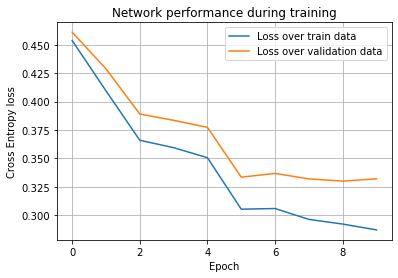

In [393]:
plt.plot(train_loss_log, label = 'Loss over train data')
plt.plot(val_loss_log, label = 'Loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy loss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

## Random Search 
Now this section is dedicated to the search of hyperparametrs with a random search. The parameters to be optimized will be
+ Number of channels of the first and second convolutional layer
+ Number of nodes of the Fully connected layer
+ Dropout probability
+ The optimizer algorithm (between adam and adamax)
+ the learning rate
+ the number of epochs
+ the weight decay

As the previous task, the results of the search stem from a Cross validation setup, where the dataset is split in 4 parts.

In [397]:
def RandomSearch2(params_to_choose, Net_class, train_dataset, transform , n_folds = 4 , n_points = 5):
    """random search"""

    Ntot = len(train_dataset)
    Nval = int(Ntot/n_folds)
    cvs = torch.utils.data.random_split(train_dataset,[Nval]*n_folds)
    result_df_columns = ['mean_loss'] + list(params_to_choose.keys()) + ['losslog_cv' + str(i) for i in range(n_folds)] 

    results = pd.DataFrame(np.zeros((n_points,len(result_df_columns))),
                           columns = result_df_columns, dtype=object)

    Ni , No = 1 , 1
    act = nn.Sigmoid()    

    for i in range(n_points):

        params   = {}
        for param in params_to_choose.keys():
            params[param] = np.random.choice(params_to_choose[param])

            results[param][i] = params[param]

        print('ITERATION N ' + str(i+1))
        print('PARAMS:\n' )
        for value,name in zip(params.values(),params.keys()):
            print(name,'     \t :',value)

        val_cv_losses = []

        mean_loss = 0

        for j in range(n_folds):

            train_cv = cvs.copy()
            val_cv   = train_cv.pop(j)
            train_cv = torch.utils.data.ConcatDataset(train_cv)

            train_cv.transform = transform
            val_cv.transform   = transform


            train_dataloader = DataLoader(train_cv , batch_size=256           , shuffle=True  , num_workers=0)
            val_dataloader   = DataLoader(val_cv   , batch_size=len(val_cv) , shuffle=False , num_workers=0)  
            
            In        = (28,28)
            Out       = 10
            KSize     = [4,4]*2
            
            NChannel1 = params['NChannel1']
            NChannel2 = params['NChannel2']
            
            FCLSize   = params['FCLSize']
            init_func = params['init_func']
            p_drop    = params['p_drop']
            net       = Net_class(In,Out,[NChannel1,NChannel2],Ksize,FCLSize,
                                  init_func=init_func,pDropout=p_drop)
            net.to(device)

            loss_fn = params['loss_fn']

            optimizer = params['optimizer']
            optimizer = optimizer(net.parameters(),lr=params['lr'] , weight_decay = params['w_decay'] )

            _ , val_loss_log = train_func(net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs = params['num_epochs'], disable_tqdm=True)

            results['losslog_cv' + str(j) ][i] = val_loss_log
            mean_loss += val_loss_log[-1]     

        results['mean_loss'][i] = mean_loss/n_folds
    return results

In [398]:
params_to_choose = {
    'NChannel1' : [ 4 , 8 ],
    'NChannel2' : [ 8 , 16],
    'FCLSize'   : [64 , 128 , 256],
    'init_func' : [init_weights],
    'p_drop'    : [0.2 , 0.3 , 0.4],
    'loss_fn'   : [nn.CrossEntropyLoss()],
    'optimizer' : [optim.Adam , optim.Adamax ],
    'w_decay'   : [0 , 1e-5 , 1e-4],
    'lr'        : [1e-4 , 1e-3],
    'num_epochs': [10 , 15]
    #'l1lambda'  : [1e-5,1e-4]
}

In order to speed up the search, a smaller dataset is fed to the random search, wich is a fourth of the total.

In [399]:
# Smaller train dataset to speed up the random search.  
Ntot = len(train_dataset)
NSmall = int(Ntot/4)
small_train_dataset , _ = torch.utils.data.random_split(train_dataset , [ NSmall , Ntot - NSmall ])

The search will be performed with a 4 fold cross validation setup and a serach over 10 random points.

In [400]:
results = RandomSearch2(params_to_choose,ConvNet,small_train_dataset,train_transform,n_points=10)

ITERATION N 1
PARAMS:

NChannel1      	 : 4
NChannel2      	 : 8
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.2
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0
lr      	 : 0.001
num_epochs      	 : 10
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.35s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.04s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.99s/it]


ITERATION N 2
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 8
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.4
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 1e-05
lr      	 : 0.001
num_epochs      	 : 10
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.26s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.11s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.56s/it]


ITERATION N 3
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 8
FCLSize      	 : 128
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.3
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 1e-05
lr      	 : 0.001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.17s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.20s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:01<00:00,  4.11s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:01<00:00,  4.10s/it]


ITERATION N 4
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 16
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.4
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 1e-05
lr      	 : 0.0001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.34s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.45s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.36s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.36s/it]


ITERATION N 5
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 8
FCLSize      	 : 256
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.4
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 1e-05
lr      	 : 0.0001
num_epochs      	 : 10
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.45s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.74s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.54s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


ITERATION N 6
PARAMS:

NChannel1      	 : 4
NChannel2      	 : 8
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.3
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adam.Adam'>
w_decay      	 : 0.0
lr      	 : 0.001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.31s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.29s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.59s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.53s/it]


ITERATION N 7
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 16
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.4
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0001
lr      	 : 0.001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.49s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.37s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.50s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.51s/it]


ITERATION N 8
PARAMS:

NChannel1      	 : 4
NChannel2      	 : 16
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.3
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0
lr      	 : 0.0001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.42s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:09<00:00,  4.64s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.54s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.37s/it]


ITERATION N 9
PARAMS:

NChannel1      	 : 4
NChannel2      	 : 8
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.2
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 1e-05
lr      	 : 0.0001
num_epochs      	 : 15
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:05<00:00,  4.35s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.25s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.25s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.24s/it]


ITERATION N 10
PARAMS:

NChannel1      	 : 8
NChannel2      	 : 16
FCLSize      	 : 64
init_func      	 : <function init_weights at 0x000001680A229E18>
p_drop      	 : 0.3
loss_fn      	 : CrossEntropyLoss()
optimizer      	 : <class 'torch.optim.adamax.Adamax'>
w_decay      	 : 0.0
lr      	 : 0.001
num_epochs      	 : 10
Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.60s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.47s/it]


Network initialized


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]


In [402]:
results

,mean_loss,NChannel1,NChannel2,FCLSize,init_func,p_drop,loss_fn,optimizer,w_decay,lr,num_epochs,losslog_cv0,losslog_cv1,losslog_cv2,losslog_cv3
0,tensor(0.6367),4,8,64,<function init_weights at 0x000001680A229E18>,0.2,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,0,0.001,10,"[tensor(1.9319), tensor(1.2430), tensor(0.9735...","[tensor(2.0406), tensor(1.4849), tensor(1.0433...","[tensor(1.8606), tensor(1.1910), tensor(0.8721...","[tensor(1.7814), tensor(1.1611), tensor(0.9307..."
1,tensor(0.7882),8,8,64,<function init_weights at 0x000001680A229E18>,0.4,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,1e-05,0.001,10,"[tensor(2.2317), tensor(2.1259), tensor(1.8143...","[tensor(2.0322), tensor(1.6587), tensor(1.3209...","[tensor(2.1343), tensor(1.8699), tensor(1.4221...","[tensor(1.9752), tensor(1.5489), tensor(1.2357..."
2,tensor(0.4493),8,8,128,<function init_weights at 0x000001680A229E18>,0.3,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,1e-05,0.001,15,"[tensor(1.1920), tensor(0.8248), tensor(0.6849...","[tensor(1.2188), tensor(0.7793), tensor(0.6751...","[tensor(1.0431), tensor(0.7342), tensor(0.6451...","[tensor(0.9700), tensor(0.7632), tensor(0.6665..."
3,tensor(0.9326),8,16,64,<function init_weights at 0x000001680A229E18>,0.4,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,1e-05,0.0001,15,"[tensor(2.1690), tensor(2.0951), tensor(2.0281...","[tensor(2.1960), tensor(2.1266), tensor(2.0440...","[tensor(2.1818), tensor(2.1058), tensor(2.0323...","[tensor(2.2195), tensor(2.1302), tensor(2.0359..."
4,tensor(1.8274),8,8,256,<function init_weights at 0x000001680A229E18>,0.4,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,1e-05,0.0001,10,"[tensor(2.2601), tensor(2.1659), tensor(2.1078...","[tensor(2.1998), tensor(2.1559), tensor(2.1136...","[tensor(2.3510), tensor(2.2057), tensor(2.1171...","[tensor(2.3399), tensor(2.2664), tensor(2.2204..."
5,tensor(0.5048),4,8,64,<function init_weights at 0x000001680A229E18>,0.3,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,0,0.001,15,"[tensor(1.4708), tensor(0.8758), tensor(0.7181...","[tensor(1.6385), tensor(0.9711), tensor(0.7807...","[tensor(1.3752), tensor(0.8642), tensor(0.7313...","[tensor(1.6790), tensor(0.9142), tensor(0.7708..."
6,tensor(0.6134),8,16,64,<function init_weights at 0x000001680A229E18>,0.4,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,0.0001,0.001,15,"[tensor(1.9074), tensor(1.2328), tensor(0.9817...","[tensor(2.0297), tensor(1.6858), tensor(1.3428...","[tensor(1.7432), tensor(1.0933), tensor(0.8858...","[tensor(1.8010), tensor(1.2432), tensor(1.0218..."
7,tensor(1.5192),4,16,64,<function init_weights at 0x000001680A229E18>,0.3,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,0,0.0001,15,"[tensor(2.2884), tensor(2.2698), tensor(2.2515...","[tensor(2.2777), tensor(2.2090), tensor(2.1628...","[tensor(2.2099), tensor(2.1165), tensor(2.0497...","[tensor(2.2469), tensor(2.1981), tensor(2.1501..."
8,tensor(1.7043),4,8,64,<function init_weights at 0x000001680A229E18>,0.2,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,1e-05,0.0001,15,"[tensor(2.4474), tensor(2.2920), tensor(2.2037...","[tensor(2.2676), tensor(2.2483), tensor(2.2291...","[tensor(2.2691), tensor(2.2348), tensor(2.2045...","[tensor(2.3094), tensor(2.2557), tensor(2.2190..."
9,tensor(0.6067),8,16,64,<function init_weights at 0x000001680A229E18>,0.3,CrossEntropyLoss(),<class 'torch.optim.adamax.Adamax'>,0,0.001,10,"[tensor(1.5490), tensor(1.0681), tensor(0.9050...","[tensor(1.5768), tensor(0.9637), tensor(0.8062...","[tensor(1.5971), tensor(0.9833), tensor(0.8223...","[tensor(1.4283), tensor(0.9871), tensor(0.8481..."


In [403]:
best_results = results.loc[results.mean_loss.apply(float).idxmin()]
best_results

mean_loss                                         tensor(0.4493)
NChannel1                                                      8
NChannel2                                                      8
FCLSize                                                      128
init_func          <function init_weights at 0x000001680A229E18>
p_drop                                                       0.3
loss_fn                                       CrossEntropyLoss()
optimizer                        <class 'torch.optim.adam.Adam'>
w_decay                                                    1e-05
lr                                                         0.001
num_epochs                                                    15
losslog_cv0    [tensor(1.1920), tensor(0.8248), tensor(0.6849...
losslog_cv1    [tensor(1.2188), tensor(0.7793), tensor(0.6751...
losslog_cv2    [tensor(1.0431), tensor(0.7342), tensor(0.6451...
losslog_cv3    [tensor(0.9700), tensor(0.7632), tensor(0.6665...
Name: 2, dtype: object

The random search showed again that regularizations schemes such as weight decay (or L2 regularization) and dropout help in the training procedures. Also the netwrok size has not been chosen too big neither too small, since these extremes tend to either overfit or be too simple. Adam seems to be the best optimizer and the number of epochs is set at 15

In [405]:
batch_size = 256
train_dataloader = DataLoader(train_dataset , batch_size=batch_size           , shuffle=True  , num_workers=0)
val_dataloader   = DataLoader(val_dataset   , batch_size=len(val_dataset) , shuffle=False , num_workers=0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


torch.manual_seed(0)
In        = (28,28)
Out       = 10
NChannels = [best_results.NChannel1,best_results.NChannel2]
Ksize     = [(4,4)]*2
FCLSize   = best_results.FCLSize

Net = ConvNet(In,Out,NChannels,Ksize,FCLSize,pDropout = best_results.p_drop)

loss_fn = nn.CrossEntropyLoss()

optimizer = best_results.optimizer(Net.parameters(), lr=best_results.lr
                                   ,weight_decay=best_results.w_decay)

Net(train_dataset[78][0].unsqueeze(0).to(device))


Training device: cpu
Network initialized


tensor([[ 0.2541, -0.0367,  0.1540,  0.5659,  0.1163,  0.1763, -0.1659, -0.3629,
          0.3576, -0.0069]], grad_fn=<AddmmBackward>)

In [406]:
train_loss_log, val_loss_log = train_func(Net,train_dataloader,val_dataloader,device,
                                          loss_fn, optimizer, verbose=0,
                                          num_epochs=best_results.num_epochs, disable_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:46<00:00, 19.13s/it]


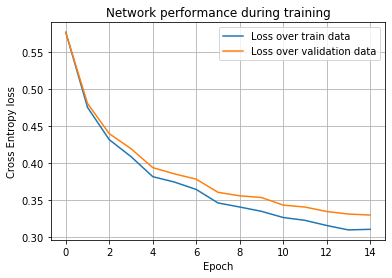

In [407]:
plt.plot(train_loss_log, label = 'Loss over train data')
plt.plot(val_loss_log, label = 'Loss over validation data')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy loss')
plt.title('Network performance during training')
plt.legend()
plt.grid()
plt.show()

### Analysis of the results of the random search

The best way to evaluate the performance of a supervised learning classifier algorithm is to plot the **confusion matrix**, which will help to see the performance for each class of object, by creating a matrix with on the rows the true label of the samples and on the columns the predicted label. The value of the overall performance of this step is determined by the accuracy more than the value of the loss function. The perfect classifier will put every sample on the diagonal, so the way that the network will deviate from this ideal gives a measure on how much it's getting wrong, and in what way it is failing.

In [408]:
sm = torch.nn.Softmax(dim=1)

val_out, val_labels , valloss = test_epoch(Net,device,test_dataloader,loss_fn)
val_out        = np.array(sm(val_out))
val_out_labels = np.argmax(val_out,axis=1)
val_acc = 100*(sum(np.array(val_labels)==val_out_labels))/val_out_labels.shape
classes = test_dataset.classes
NClass = len(classes)
Conf_matrix = np.zeros([ NClass , NClass ])
for i in np.arange(val_out_labels.size):
    Conf_matrix[ val_labels[i] , val_out_labels[i] ] += 1
_, n_of_labels = np.unique(val_labels, return_counts = True)
Conf_matrix = Conf_matrix.T/Conf_matrix.T.sum(axis=0)

In [409]:
Conf_matrix = Conf_matrix.T

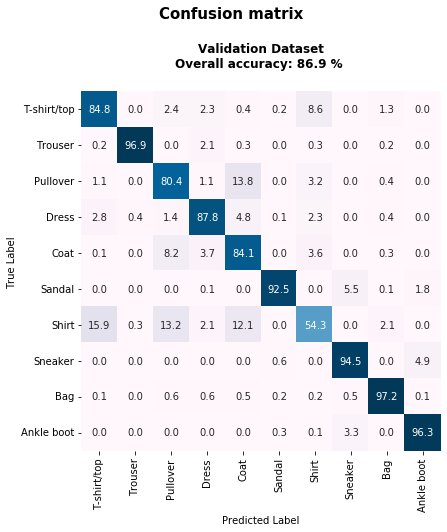

In [410]:
import seaborn as sns
fig,ax=plt.subplots(figsize=[7,7])
plt.suptitle('Confusion matrix',y=1.05,fontsize=15,weight='bold')



df_Confusion = pd.DataFrame( Conf_matrix*100 ,classes,classes)



sns.heatmap(df_Confusion, ax = ax, cmap = 'PuBu', square = True, annot = True , fmt = '.1f', 
            cbar = False, cbar_kws = {"shrink": 0.56} )

ax.set_title('Validation' + f' Dataset\nOverall accuracy: {val_acc[0]:.1f} % ', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

ax.set_ylim(10,-0.5, -0.5)
plt.tight_layout()
#plt.savefig('net_out.png')
plt.show()

### Visualization of the weigths

To see if the convolution windows encompass some  recognisable features we will try to visualize the weights, both of the first and the second convolutional layer.

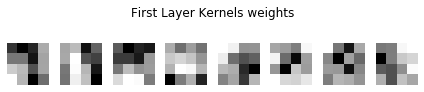

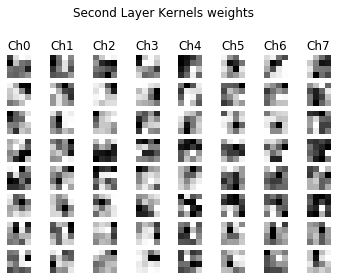

In [411]:
fig = plt.figure()
plt.suptitle('First Layer Kernels weights',y=0.7)
Conv1  = Net.ConvLayer[0].weight.data.numpy()
Ch1    = Conv1.shape[0]
                

for i in np.arange(Ch1):
    ax = fig.add_subplot(1,Ch1,i+1)
    ax.imshow(Conv1[i,0,:,:],cmap='Greys')
    ax.axis('off')
plt.tight_layout()
plt.show()
fig = plt.figure()
plt.suptitle('Second Layer Kernels weights',y=1.05)
Conv2  = Net.ConvLayer[3].weight.data.numpy()
Ch1 = Conv2.shape[0]
Ch2 = Conv2.shape[1]



for i in np.arange(Ch1):
    for j in np.arange(Ch2):
        ax = fig.add_subplot(Ch1,Ch2,i*Ch2+j+1)
        if i==0:
            ax.set_title('Ch'+str(j))
        ax.imshow(Conv2[i,j,:,:],cmap='Greys')
        ax.axis('off')
#        ax.set_title(str(i) + str(j))
#plt.tight_layout()
plt.show()

As it could be expected, no discernable features are apparent in the weights and to human eyes look just like random noise.

The next section is dedicated to look for features in the activation profiles of the network last convolutional layer, after an image has been passed throught. This should results in a number of activation profiles equal to the number of last layer channels.

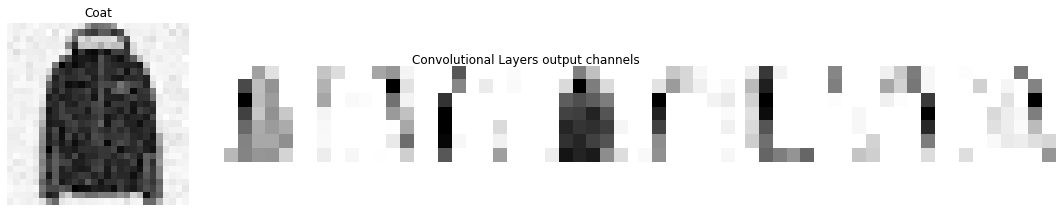

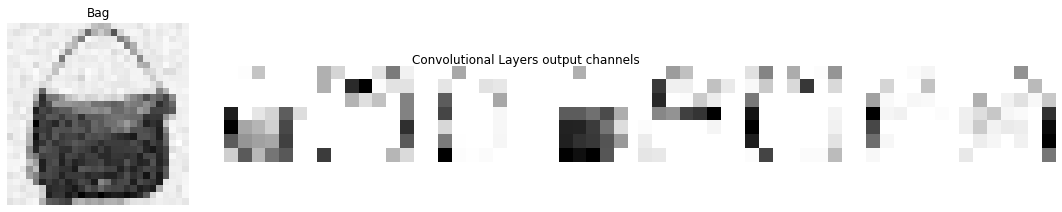

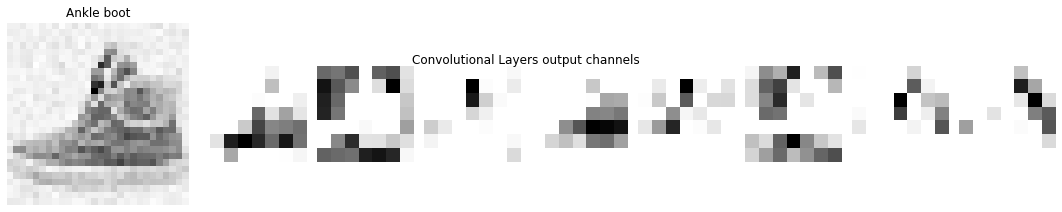

In [413]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook
def ConvActivationVisualizer(Net,figsize,classes,test_image,label):
    hook_handle = Net.ConvLayer.register_forward_hook(get_activation)

    Net = Net.to(device)
    Net.eval()


    with torch.no_grad():
        y1 = Net(test_image.unsqueeze(0))
        z1 = activation
    hook_handle.remove()
    Ch1    = z1.shape[1]


    fig = plt.figure(figsize=figsize)
    plt.subplot2grid((2,Ch1+2),(0,0),colspan=2,rowspan=2)
    plt.imshow(test_image.squeeze(0),cmap='Greys')
    plt.title(classes[label])
    plt.axis('off')


    plt.suptitle('Convolutional Layers output channels',y=0.75)

    for i in np.arange(Ch1):
        ax = fig.add_subplot(1,Ch1+2,i+3)
        ax.imshow(z1[0,i,:,:],cmap='Greys')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


figsize = [15,3]
ConvActivationVisualizer(Net,figsize,classes,*val_dataset[1])
ConvActivationVisualizer(Net,figsize,classes,*val_dataset[10])
ConvActivationVisualizer(Net,figsize,classes,*val_dataset[1000])

Some features of the original image are still visible in the actvations, but is difficult to know what the network is doing under the hood. The only recognaizable behaviours are that some channels seems to be more sensitive to vertical, horizontal or diagonal edges, wich is a feature of many convolutional neural networks that work with images.

## Results.

The Convolutional neural network was succesfully able to achieve a pretty good performance in classifing the different classes, as is possible to see from the confusion matrix. Some classes are easily confused, as is the case with similar items of clothing, like the coat-pullover and shirt- T-shirt pairs. Classes of sample with a very different appearance than the rest, like trousers, seem to achieve really high accuracies. 

The meauser taken to avoid overfitting, like the addition of weight decay in the optimizer algorithm and the dropout, seems to be effective, since the difference between training and validation are not too great.

The addition of input modification seems to also do the job, by helping the network to generalize its results.

To improve performances, in the future it might help to find different strategies to modify the input even more, and also add layers and complexity to the network
